# Goals

1. Define Dataset with SRM-IL (style randomizations - image level)
2. Define SRM-FL as a Separate Model (feature randomizations - feature level)
3. Integrate SRM-FL into AlexNet

Reference: https://github.com/rafizunaed/DomainAgnosticCXR/tree/main/

## Imports

In [ ]:
!pip install opendatasets

In [ ]:
import os
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms
from PIL import Image
import opendatasets as od
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import alexnet
import matplotlib.pyplot as plt
import numpy as np
from timm.utils.model_ema import ModelEmaV2

## Download Dataset and create Dataloader

In [ ]:
od.download("https://www.kaggle.com/datasets/emilyguan2/covid-dataset/data ")
od.download("https://www.kaggle.com/datasets/andreacheng41/bangladesh-chestxray-dlproject")
od.download("https://www.kaggle.com/datasets/mahdiopra/rsua-chest-x-ray-dataset")
od.download("https://www.kaggle.com/datasets/emilyguan2/nigeria-only/data")

Dataset URL: https://www.kaggle.com/datasets/emilyguan2/covid-dataset


100%|██████████| 185M/185M [00:01<00:00, 106MB/s]



Dataset URL: https://www.kaggle.com/datasets/andreacheng41/bangladesh-chestxray-dlproject


100%|██████████| 42.7M/42.7M [00:00<00:00, 139MB/s]



Dataset URL: https://www.kaggle.com/datasets/mahdiopra/rsua-chest-x-ray-dataset


100%|██████████| 109M/109M [00:01<00:00, 90.1MB/s]



Dataset URL: https://www.kaggle.com/datasets/emilyguan2/nigeria-only


100%|██████████| 187M/187M [00:02<00:00, 81.9MB/s]


### SRM IL Class

Applies a normalization formula to an image's pixel values.
The paper provides the min_value and max_value using defined global config variables, but for simplicity we just default them to 0 and 255 (which is what the config variables are set to)

In [ ]:
class SRM_IL(object):
    def __init__(self, min_value=0, max_value=255):
        self.max_value = max_value
        self.min_value = min_value

    def apply_perturbation(self, image):
        image = image.astype(np.float32)
        m2 = np.random.uniform(low=self.min_value, high=self.max_value, size=(1,1,1)).repeat(3, axis=2)
        s2 = np.random.uniform(low=self.min_value, high=self.max_value, size=(1,1,1)).repeat(3, axis=2)
        m1 = np.mean(image, axis=(0,1), keepdims=True)
        v1 = np.var(image, axis=(0,1), keepdims=True)
        s1 = np.sqrt(v1)
        image = (image - m1) / s1
        image = image * s2 + m2
        return image

### CXRDataset Class

Defines a Dataset object for the Covid19 Radiography Database
Uses the SRM-IL class to randomly

In [ ]:
class CXREpisodicDataset(Dataset):
    def __init__(self, path, folder_mapping, sub_folder=None, transform=None,
                 use_SRM_IL=True, srm_il_min=0, srm_il_max=255,
                 print_img=False,
                 use_episodic=False, support_path=None, support_folder_mapping=None, support_sub_folder=None,
                 num_support_per_batch=None, num_query_per_batch=None):
        """
        Args:
            folder_mapping (dict): A dictionary where keys are target labels and values are lists of folder paths.
                                   Example: {"Normal": ["path_to_Normal_folder"],
                                             "Non-Pneumonia Disease": ["path_to_COVID", "path_to_Lung_Opacity"],
                                             "Pneumonia": ["path_to_Viral_Pneumonia"]}
            transform (callable, optional): Optional transforms to be applied on an image.
            use_SRM_IL (boolean): Indicates use of SRM IL perturbations on an image.
        """
        self.print_img = print_img
        self.data = []
        self.labels = []
        self.transform = transform
        self.use_SRM_IL = use_SRM_IL
        self.use_episodic = use_episodic
        self.support_data = []
        self.support_labels = []

        # Load all images and assign corresponding labels
        self.data, self.labels = self.load_images(path, folder_mapping, sub_folder)
        self.len = len(self.data)

        if self.use_episodic:
          assert(support_path and support_folder_mapping)
          self.support_data, self.support_labels = self.load_images(support_path, support_folder_mapping, support_sub_folder)

          assert(num_support_per_batch or num_query_per_batch)

          if num_support_per_batch and num_query_per_batch:
            assert((len(self.data) // num_query_per_batch) == (len(self.support_data) // num_support_per_batch))
          elif num_support_per_batch:
            self.num_support_per_batch = num_support_per_batch
            num_batches = len(self.data) // num_support_per_batch
            self.num_query_per_batch = len(self.data) // num_batches
          elif num_query_per_batch:
            self.num_query_per_batch = num_query_per_batch
            num_batches = len(self.data) // num_query_per_batch

            self.num_support_per_batch = len(self.support_data) // num_batches
          print(f'{num_batches} batches')
          print(f'{self.num_query_per_batch} query data per batch; {len(self.data)} total data')
          print(f'{self.num_support_per_batch} support data per batch; {len(self.support_data)} total data')

          self.len = len(self.data) // num_query_per_batch


        # Define SRM_IL class
        if self.use_SRM_IL:
            self.SRM_IL = SRM_IL(srm_il_min, srm_il_max)

    def load_images(self, path, folder_mapping, sub_folder=None):
        data_arr = []
        label_arr = []
        for label, folders in folder_mapping.items():
            for folder in folders:
                folder_path = os.path.join(path, folder)
                if sub_folder:
                    folder_path = os.path.join(folder_path, sub_folder)

                for file_name in os.listdir(folder_path):
                    if file_name.endswith(('.png', '.jpg', '.jpeg', '.bmp')):  # Filter image files
                        img_path = os.path.join(folder_path, file_name)
                        data_arr.append(img_path)
                        label_arr.append(label)

        # shuffle data
        indices = np.random.permutation(len(data_arr))

        data_arr = np.array(data_arr)[indices]
        label_arr = np.array(label_arr)[indices]

        return data_arr, label_arr

    def __len__(self):
        return self.len


    def process_image(self, image_path):
        image = Image.open(image_path).convert("RGB")

        # Load image
        image = Image.open(image_path).convert("RGB")

        # Apply perturbation
        image = np.array(image)
        if self.use_SRM_IL:
            image = self.SRM_IL.apply_perturbation(image.copy())
        image = Image.fromarray(image.astype('uint8'))

        # Apply transformations
        if self.transform:
          image = self.transform(image)

        if self.print_img:
          plt.imshow(np.array(image))
          plt.show()

        return image

    def __getitem__(self, idx):
        if self.use_episodic:
          img_paths = self.data[idx*self.num_query_per_batch:(idx+1)*self.num_query_per_batch]
          labels = self.labels[idx*self.num_query_per_batch:(idx+1)*self.num_query_per_batch]

          support_img_paths = self.support_data[idx*self.num_support_per_batch:(idx+1)*self.num_support_per_batch]
          support_labels = self.support_labels[idx*self.num_support_per_batch:(idx+1)*self.num_support_per_batch]

          images = [self.process_image(img_path) for img_path in img_paths]
          support_images = [self.process_image(img_path) for img_path in support_img_paths]

          return torch.stack(images), torch.tensor(labels).reshape(-1), torch.stack(support_images), torch.tensor(support_labels).reshape(-1)
        else:
          img_path = self.data[idx]
          label = self.labels[idx]

          return self.process_image(img_path), torch.tensor(label)


In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

srm_il_min = 0
srm_il_max = 255

train_data_dir = "covid-dataset"

train_folder_map = {
    0: ["A_normal_sample"],
    1: ["A_other_sample"],
    2: ["A_pn_sample"]
}

support_data_dir = "nigeria-only"
support_folder_map = {
    0: ["nigeria_normal/nigeria_normal"],
    1: ["nigeria_other/nigeria_other"],
    2: ["nigeria_pneumonia/nigeria_pneumonia"],
}
train_dataset = CXREpisodicDataset(train_data_dir, train_folder_map,
                                   transform=transform, use_SRM_IL=True, srm_il_min=srm_il_min, srm_il_max=srm_il_max,
                                   use_episodic=True, support_path=support_data_dir, support_folder_mapping=support_folder_map,
                                   num_query_per_batch=32)


162 batches
32 query data per batch; 5200 total data
12 support data per batch; 1951 total data


In [ ]:
# validation dataset

val_data_dir = "bangladesh-chestxray-dlproject"

val_folder_map = {
    0: ["Normal"],
    1: ["COVID", "Lung_Opacity"],
    2: ["Viral Pneumonia"]
}

val_dataset = CXREpisodicDataset(val_data_dir, val_folder_map, transform=transform, use_SRM_IL=False, use_episodic=False)

# test dataset
test_data_dir = "rsua-chest-x-ray-dataset/RSUA Chest X-Ray Dataset/Data Chest X-Ray RSUA (Annotated)-20230618T030427Z-001/Data Chest X-Ray RSUA (Annotated)"

test_folder_map = {
    0: [ "Non_Covid/images"],
    1: ["Covid/images"],
    2: [ "Non_Covid_Pneumonia/images"]
}


test_dataset = CXREpisodicDataset(test_data_dir, test_folder_map, transform=transform, use_SRM_IL=False, use_episodic=False)

In [ ]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

162
4350
371


In [ ]:
count = 0
for images, labels, support_images, support_labels in train_loader:
  print("-----")
  print(images[0].shape)
  for img in images:
    print(img.shape)
  print(labels[0].shape)
  for support_img in support_images:
    print(support_img.shape)
  print(support_labels.shape)
  count += 1
  if count == 2:
    break

-----
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([12, 3, 224, 224])
torch.Size([1, 12])
-----
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([12, 3, 224, 224])
torch.Size([1, 12])


## Define AlexNet Architecture with Feature Level Perturbation Blocks

The paper/github integrates a separate SRM_FL block into the Densenet architecture; here, we integrate the SRM_FL block into the Alexnet architecture

### SRM FL Class

In [ ]:
class SRM_FL(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.eps = 1e-7
        self.gamma_net = nn.Sequential(
                            nn.Conv2d(in_channels, in_channels, 1, 1),
                            nn.Conv2d(in_channels, in_channels//2, 3, 1, 1),
                            nn.Conv2d(in_channels//2, in_channels, 3, 1, 1),
                            nn.Conv2d(in_channels, in_channels, 1, 1),
                            )
        self.beta_net = nn.Sequential(
                            nn.Conv2d(in_channels, in_channels, 1, 1),
                            nn.Conv2d(in_channels, in_channels//2, 3, 1, 1),
                            nn.Conv2d(in_channels//2, in_channels, 3, 1, 1),
                            nn.Conv2d(in_channels, in_channels, 1, 1),
                            )

    def forward(self, content_feats_orig:torch.Tensor, style_feats:torch.Tensor):
        gamma = self.gamma_net(style_feats)
        beta = self.beta_net(style_feats)
        mean_content = torch.mean(content_feats_orig, dim=[2,3], keepdim=True)
        var_content = torch.var(content_feats_orig, dim=[2,3], keepdim=True)
        content_feats = (content_feats_orig - mean_content) / (var_content + self.eps).sqrt()
        content_feats = content_feats * gamma + beta
        return content_feats

### Loss function for SRM_FL

In [ ]:
import torch.nn.functional as F

def generate_gram_matrix(x:torch.Tensor):
    (b, ch, h, w) = x.size()
    features = x.view(b, ch, w * h)
    features = F.normalize(features, dim=2, eps=1e-7)
    features_t = features.transpose(1, 2)
    gram_matrix = features.bmm(features_t)
    return gram_matrix

def calculate_content_style_loss(transformed:torch.Tensor, content_ref:torch.Tensor, style_ref:torch.Tensor):
    content_loss = F.mse_loss(transformed, content_ref)
    gm_transformed = generate_gram_matrix(transformed)
    gm_style_ref = generate_gram_matrix(style_ref)
    style_loss = F.mse_loss(gm_transformed, gm_style_ref)
    return content_loss, style_loss

### AlexNet with SRM FL Blocks

Removing randomization_stage parameter and simply integrating the SRMFL block where convenient for now

In [ ]:
from torch.cuda.amp import autocast

class AlexNet_SRMFL(nn.Module):
    def __init__(self, num_classes: int, init_srm_fl=False, randomization_stage=None):
          super().__init__()
          self._init_backbone()
          self._init_head(num_classes)
          self.init_srm_fl = init_srm_fl
          self.randomization_stage = randomization_stage

          # Validate init_srm_fl is True <=> randomization_stage is not None
          if init_srm_fl == True:
            assert randomization_stage in ['S1', 'S2', 'S3']
          if randomization_stage != None:
            assert init_srm_fl == True

          # SRM_FL expected input based on location in AlexNet
          if randomization_stage == 'S1':
              self.srm_fl = SRM_FL(192)
          elif randomization_stage == 'S2':
              self.srm_fl = SRM_FL(384)
          elif randomization_stage == 'S3':
              self.srm_fl = SRM_FL(256)


    def _init_backbone(self):
        # Load AlexNet pretrained model
        model = alexnet(pretrained=True)
        features = list(model.features)
        # Split AlexNet layers into blocks for S1, S2, S3 stages
        self.stem = nn.Sequential(*features[:3])  # Layers 0-2
        self.conv_block1 = nn.Sequential(*features[3:6])  # Layers 3-5
        self.conv_block2 = nn.Sequential(*features[6:8])  # Layers 6-7
        self.conv_block3 = nn.Sequential(*features[8:])   # Layers 8-12

        # Global average pooling
        self.avg = nn.AdaptiveAvgPool2d((6, 6))

    def _init_head(self, num_classes: int):
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def grad_turn_on_srm_fl_only(self):
        for x in [self.stem, self.conv_block1, self.conv_block2, self.conv_block3, self.classifier]:
            for _, p in enumerate(x.parameters()):
                p.requires_grad_(False)

        for _, p in enumerate(self.srm_fl.parameters()):
            p.requires_grad_(True)

    def grad_turn_off_srm_fl_only(self):
        for x in [self.stem, self.conv_block1, self.conv_block2, self.conv_block3, self.classifier]:
            for _, p in enumerate(x.parameters()):
                p.requires_grad_(True)

        for _, p in enumerate(self.srm_fl.parameters()):
            p.requires_grad_(False)

    def _forward_block(self, block, x: torch.Tensor):
        x = block(x)
        return x

    def _perturb_features(self, x: torch.Tensor, train_srm_fl: bool):
        N = x.shape[0]
        idx_swap = torch.arange(N).flip(0)
        cont_x = x.clone()
        style_x = x.clone()[idx_swap].detach()
        x_srm = self.srm_fl(cont_x, style_x)
        if train_srm_fl:
            content_loss, style_loss = calculate_content_style_loss(x_srm, cont_x, style_x)
            return {
                'content_loss': content_loss,
                'style_loss': style_loss,
                }
        else:
            return x_srm

    def forward_to_srm_fl(self, x: torch.Tensor, before=True):
      x = self.stem(x)
      x = self._forward_block(self.conv_block1, x)
      if self.randomization_stage == 'S1':
          if before:
            return x
          x = self._perturb_features(x, train_srm_fl=False)
          return x
      x = self._forward_block(self.conv_block2, x)
      if self.randomization_stage == 'S2':
          if before:
            return x
          x = self._perturb_features(x, train_srm_fl=False)
          return x
      x = self._forward_block(self.conv_block3, x)
      if self.randomization_stage == 'S3':
          if before:
            return x
          x = self._perturb_features(x, train_srm_fl=False)
          return x
      return x

    @autocast()
    def forward(self, x: torch.Tensor, use_srm_fl: bool = False, train_srm_fl: bool = False):
        if not self.init_srm_fl or not use_srm_fl:
            x = self.stem(x)
            x = self._forward_block(self.conv_block1, x)
            x = self._forward_block(self.conv_block2, x)
            x = self._forward_block(self.conv_block3, x)
            x = torch.flatten(x, 1)
            logits = self.classifier(x)
        else:
            x = self.stem(x)

            x = self._forward_block(self.conv_block1, x)
            if self.randomization_stage == 'S1' and use_srm_fl:
                x = self._perturb_features(x, train_srm_fl)
                if train_srm_fl:
                    return x

            x = self._forward_block(self.conv_block2, x)
            if self.randomization_stage == 'S2' and use_srm_fl:
                x = self._perturb_features(x, train_srm_fl)
                if train_srm_fl:
                    return x

            x = self._forward_block(self.conv_block3, x)
            if self.randomization_stage == 'S3' and use_srm_fl:
                x = self._perturb_features(x, train_srm_fl)
                if train_srm_fl:
                    return x

            x = self.avg(x)
            x = torch.flatten(x, 1)
            logits = self.classifier(x)

        return {
            'logits': logits,
            'gfm': x,
        }

<ipython-input-13-1865aa09a414>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast()


## Train Model

References the `ModelTrainer_SRM_IL_FL()` class in the paper's repo

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ModelTrainer():
    def __init__(self,
                 model: torch.nn.Module,
                 Loaders: list,
                 lr: float,
                 epochsTorun: int,
                 do_grad_accum: False,
                 grad_accum_step: int,
                 use_ema: bool,
                 eta: float,
                 use_SRM_FL: False,
                 use_episodic: False
                 ):
        super().__init__()

        self.model = model.to(DEVICE)
        self.trainLoader = Loaders[0]
        self.valLoader = Loaders[1]
        self.eta = eta
        self.lr = lr
        self.epochsTorun = epochsTorun

        self.criterion_cls = nn.CrossEntropyLoss()

        self.scaler = torch.cuda.amp.GradScaler()
        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=self.lr)

        self.do_grad_accum = do_grad_accum
        self.grad_accum_step = grad_accum_step

        self.use_ema = use_ema
        if self.use_ema:
            self.model_ema = ModelEmaV2(self.model, decay=0.997, device=DEVICE)

        self.use_SRM_FL = use_SRM_FL

        self.use_episodic = use_episodic

        if (use_episodic):
          assert(use_SRM_FL) # episodic training only relevant to FL

    def save_checkpoint(self, epoch, train_loss, train_acc, val_loss, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scaler_state_dict': self.scaler.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        }

        if self.use_ema:
            checkpoint['model_ema_state_dict'] = self.model_ema.state_dict()

        torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
        print(f"Checkpoint saved for epoch {epoch}")

    def load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scaler.load_state_dict(checkpoint['scaler_state_dict'])

        if self.use_ema and 'model_ema_state_dict' in checkpoint:
            self.model_ema.load_state_dict(checkpoint['model_ema_state_dict'])

        return checkpoint['epoch']


    def perform_validation(self, use_progbar=True):
        self.model.eval()
        if self.use_ema:
            self.model_ema.eval()
        torch.set_grad_enabled(False)

        print(f'(Val) Epoch {self.current_epoch_no}/{self.epochsTorun}')

        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in self.valLoader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            with torch.no_grad() and torch.amp.autocast(device_type='cuda'):
                if self.use_ema:
                    out = self.model_ema.module(images)
                else:
                    out = self.model(images)
                batch_loss = self.criterion_cls(out['logits'], labels)
                running_loss += batch_loss.item()

            # update metrics
            _, predicted = out['logits'].max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # calculate metrics and return
        epoch_loss = running_loss / len(self.valLoader)
        epoch_accuracy = correct / total
        return epoch_loss, epoch_accuracy

    def train_one_epoch_style_net(self):

        print(f'(Train Style Net) Epoch {self.current_epoch_no}/{self.epochsTorun}')

        self.model.train()
        torch.set_grad_enabled(True)
        self.optimizer.zero_grad()

        if self.use_ema:
            self.model_ema.train()

        self.model.grad_turn_on_srm_fl_only()

        running_content_loss = 0.0
        running_style_loss = 0.0

        for itera_no, (images, labels) in enumerate(self.trainLoader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            with torch.cuda.amp.autocast():
                out = self.model(images, use_srm_fl=True, train_srm_fl=True)
                content_loss = out['content_loss'].mean()
                style_loss = self.eta * out['style_loss'].mean()
            self.scaler.scale(content_loss+style_loss).backward()

            if self.do_grad_accum:
                if (itera_no+1)%self.grad_accum_step == 0:
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    self.optimizer.zero_grad()

                    if self.use_ema:
                        self.model_ema.update(self.model)
            else:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()

                if self.use_ema:
                    self.model_ema.update(self.model)

            # update metrics
            running_content_loss += content_loss.detach().item()
            running_style_loss += style_loss.detach().item()

            if (itera_no+1) % 100 == 0:
                print(f'    Iter {itera_no}/{len(self.trainLoader)} | Train Content Loss: {content_loss}, Train Style Loss: {style_loss}')

        # calculate metrics and return
        epoch_content_loss = running_content_loss / len(self.trainLoader)
        epoch_style_loss = running_style_loss / len(self.trainLoader)
        return epoch_content_loss, epoch_style_loss

    def train_one_epoch(self):

        print(f'(Train Classifier) Epoch {self.current_epoch_no}/{self.epochsTorun}')

        self.model.train()
        torch.set_grad_enabled(True)
        self.optimizer.zero_grad()

        if self.use_ema:
            self.model_ema.train()

        self.model.grad_turn_off_srm_fl_only()

        running_loss = 0.0
        correct = 0
        total = 0

        for itera_no, (images, labels) in enumerate(self.trainLoader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            with torch.cuda.amp.autocast():
                out = self.model(images, use_srm_fl=True, train_srm_fl=False)
                cls_loss = self.criterion_cls(out['logits'], labels)
                batch_loss = cls_loss

            self.scaler.scale(batch_loss).backward()

            if self.do_grad_accum:
                if (itera_no+1)%self.grad_accum_step == 0:
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    self.optimizer.zero_grad()

                    if self.use_ema:
                        self.model_ema.update(self.model)
            else:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()

                if self.use_ema:
                    self.model_ema.update(self.model)

            # update metrics
            _, predicted = out['logits'].max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            running_loss += batch_loss.item()

            if itera_no % 100 == 0:
                print(f'    Iter {itera_no}/{len(self.trainLoader)} | Train Loss: {batch_loss}')

        # calculate metrics and return
        epoch_loss = running_loss / len(self.trainLoader)
        epoch_accuracy = correct / total
        return epoch_loss, epoch_accuracy

    def train_one_epoch_episodic(self):
        print(f'(Train Episodic) Epoch {self.current_epoch_no}/{self.epochsTorun}')

        self.model.train()
        torch.set_grad_enabled(True)
        self.optimizer.zero_grad()

        if self.use_ema:
            self.model_ema.train()

        running_content_loss = 0.0
        running_style_loss = 0.0
        running_loss = 0.0
        correct = 0
        total = 0

        for itera_no, (images, labels, support_images, support_labels) in enumerate(self.trainLoader):
            images, labels = images[0].to(DEVICE), labels[0].to(DEVICE)
            support_images, support_labels = support_images[0].to(DEVICE), support_labels[0].to(DEVICE)

            # first train style net
            self.model.grad_turn_on_srm_fl_only()

            with torch.cuda.amp.autocast():
                out = self.model(support_images, use_srm_fl=True, train_srm_fl=True)
                content_loss = out['content_loss'].mean()
                style_loss = self.eta * out['style_loss'].mean()
            self.scaler.scale(content_loss+style_loss).backward()

            if self.do_grad_accum:
                if (itera_no+1)%self.grad_accum_step == 0:
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    self.optimizer.zero_grad()

                    if self.use_ema:
                        self.model_ema.update(self.model)
            else:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()

                if self.use_ema:
                    self.model_ema.update(self.model)

            # update metrics for style net
            running_content_loss += content_loss.detach().item()
            running_style_loss += style_loss.detach().item()

            # print metrics for style net
            if itera_no % 100 == 0:
                print(f'    Style Net Iter {itera_no}/{len(self.trainLoader)} | Train Content Loss: {content_loss}, Train Style Loss: {style_loss}')

            # then train classifier
            self.model.grad_turn_off_srm_fl_only()

            with torch.cuda.amp.autocast():
                out = self.model(images, use_srm_fl=True, train_srm_fl=False)
                cls_loss = self.criterion_cls(out['logits'], labels)
                batch_loss = cls_loss

            self.scaler.scale(batch_loss).backward()

            if self.do_grad_accum:
                if (itera_no+1)%self.grad_accum_step == 0:
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    self.optimizer.zero_grad()

                    if self.use_ema:
                        self.model_ema.update(self.model)
            else:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()

                if self.use_ema:
                    self.model_ema.update(self.model)

            # update metrics
            _, predicted = out['logits'].max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            running_loss += batch_loss.item()

            if itera_no % 100 == 0:
                print(f'    Classifier Iter {itera_no}/{len(self.trainLoader)} | Train Loss: {batch_loss}')

        # calculate metrics and return
        epoch_content_loss = running_content_loss / len(self.trainLoader)
        epoch_style_loss = running_style_loss / len(self.trainLoader)
        epoch_loss = running_loss / len(self.trainLoader)
        epoch_accuracy = correct / total
        return epoch_content_loss, epoch_style_loss, epoch_loss, epoch_accuracy


    # train part starts here
    def fit(self, resume_from_checkpoint):

        # keep track of losses and accuracies

        train_cont_losses = []
        train_style_losses = []
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        start_epoch = 0
        if resume_from_checkpoint:
            print(f"Resuming training from epoc")
            start_epoch = self.load_checkpoint(resume_from_checkpoint)
            print(f"Resuming training from epoch {start_epoch}")

        for epoch in range(start_epoch, self.epochsTorun):
            self.current_epoch_no = epoch+1
            if self.use_episodic:
              train_content_loss, train_style_loss, train_loss, train_acc = self.train_one_epoch_episodic()
            else:
              if self.use_SRM_FL:
                train_content_loss, train_style_loss = self.train_one_epoch_style_net()
                print(f'  Train Content Loss: {train_content_loss}, Train Style Loss: {train_style_loss}')
              train_loss, train_acc = self.train_one_epoch()
            val_loss, val_acc = self.perform_validation()
            print(f'  Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

            train_cont_losses.append(train_content_loss)
            train_style_losses.append(train_style_loss)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            self.save_checkpoint(self.current_epoch_no, train_losses[-1], train_accuracies[-1], val_losses[-1], val_accuracies[-1])

        # save model, losses, and accuracies
        np.savez(
          "srm_il_fl_metrics.npz",
          train_cont_losses=train_cont_losses,
          train_style_losses=train_style_losses,
          train_losses=train_losses,
          train_accs=train_accuracies,
          val_losses=val_losses,
          val_accs=val_accuracies,
        )

        return train_cont_losses, train_style_losses, train_losses, train_accuracies, val_losses, val_accuracies

### Define model, trainer, and trainer params

In [ ]:
model = AlexNet_SRMFL(num_classes=3, init_srm_fl=True, randomization_stage='S1')

trainer_args = {
                'model': model,
                'Loaders': [train_loader, val_loader],
                'lr': 0.0001,
                'epochsTorun': 15,
                'do_grad_accum': True,
                'grad_accum_step': 4,
                'use_ema': False,
                'eta': 1.5,
                'use_SRM_FL': True,
                'use_episodic': True
}

trainer= ModelTrainer(**trainer_args)
metrics = trainer.fit(resume_from_checkpoint="episodic_eta_1_5_checkpoint_epoch_8.pth")

<ipython-input-15-9fcbc5a17efc>:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
<ipython-input-15-9fcbc5a17efc>:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have ful

Resuming training from epoc
Resuming training from epoch 8
(Train Episodic) Epoch 9/15


<ipython-input-15-9fcbc5a17efc>:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


    Style Net Iter 0/162 | Train Content Loss: 10.055481910705566, Train Style Loss: 0.04459676146507263


<ipython-input-15-9fcbc5a17efc>:271: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


    Classifier Iter 0/162 | Train Loss: 0.35382208228111267
    Style Net Iter 100/162 | Train Content Loss: 10.157820701599121, Train Style Loss: 0.10098009556531906
    Classifier Iter 100/162 | Train Loss: 0.2898034453392029
(Val) Epoch 9/15
  Train Loss: 0.3056837060937175, Train Acc: 0.8645833333333334, Val Loss: 0.7196685189709944, Val Acc: 0.6691954022988506


In [ ]:
train_cont_losses, train_style_losses, train_losses, train_accuracies, val_losses, val_accuracies = metrics

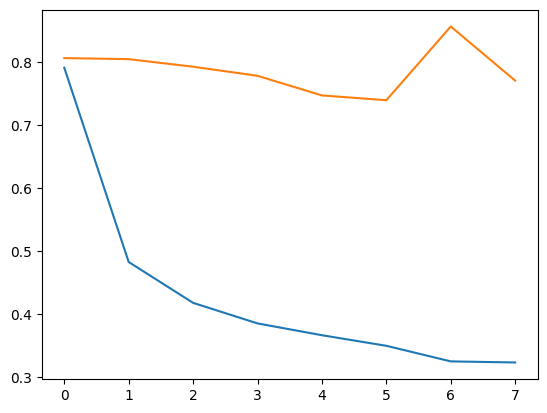

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

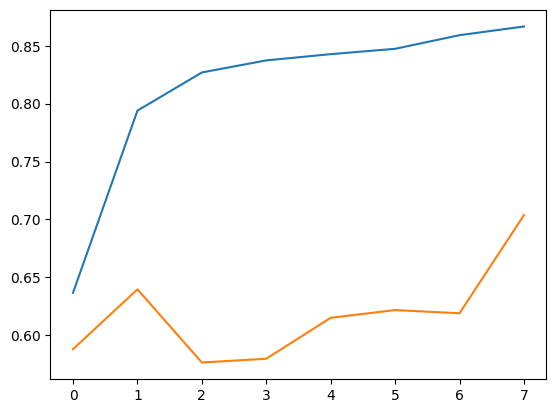

In [ ]:
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.show()

## Test Model

Using the RUSA dataset for testing, load model from checkpoint

In [ ]:
model = AlexNet_SRMFL(num_classes=3, init_srm_fl=True, randomization_stage='S1')

model.load_state_dict(torch.load('checkpoint_epoch_8.pth')['model_state_dict'])

model = model.to(DEVICE)
model.eval()
torch.set_grad_enabled(False)
correct, total = 0, 0
for images, labels in test_loader:
  images, labels = images.to(DEVICE), labels.to(DEVICE)
  with torch.no_grad() and torch.amp.autocast(device_type='cuda', enabled=True):
    # print(type(images))
    out = model(images)

    # update metrics
    _, predicted = out['logits'].max(1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)

# calculate metrics and return
accuracy = correct / total
print(f"Test Accuracy: {accuracy}")

<ipython-input-43-af710eccbfa5>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint_epoch_8.pth')['model_state_dict'])


Test Accuracy: 0.7304582210242587


### Feature Map Visualization before and after perturbations

In [ ]:
od.download("https://www.kaggle.com/datasets/emilyguan2/covid-dataset/data ")

Skipping, found downloaded files in "./covid-dataset" (use force=True to force download)


In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

srm_il_min = 0
srm_il_max = 255

vis_data_dir = "covid-dataset"

vis_folder_map = {
    0: ["A_normal_sample"],
    1: ["A_other_sample"],
    2: ["A_pn_sample"]
}

vis_dataset = CXREpisodicDataset(vis_data_dir, vis_folder_map,
                                   transform=transform, use_SRM_IL=True, srm_il_min=srm_il_min, srm_il_max=srm_il_max,
                                   use_episodic=False)

vis_loader = DataLoader(vis_dataset, batch_size=1, shuffle=False)

In [ ]:
model = AlexNet_SRMFL(num_classes=3, init_srm_fl=True, randomization_stage='S1')
model.to(DEVICE)

checkpoint_path = "checkpoint_epoch_8.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-38-10663f0fa79d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


<All keys matched successfully>

In [ ]:
for image, label in vis_loader:
  model.eval()
  image = image.to(DEVICE)
  with torch.no_grad() and torch.amp.autocast(device_type='cuda', enabled=True):
    out = model(image)
    print(out['logits'].max(1))
    print(label)
    before = model.forward_to_srm_fl(image, before=True).cpu().detach().numpy()
    after = model.forward_to_srm_fl(image, before=False).cpu().detach().numpy()

  break
  plt.show()

def visualize_feature_maps(activation):
    num_filters = 20  # Number of filters
    fig, axes = plt.subplots(4, num_filters // 4, figsize=(20, 20))
    for i in range(num_filters):
        axes[i % 4][i // 4].imshow(activation[0, i], cmap='viridis')
        axes[i % 4][i // 4].axis('off')
    plt.show()

torch.return_types.max(
values=tensor([4.7578], device='cuda:0', dtype=torch.float16),
indices=tensor([1], device='cuda:0'))
tensor([2])


#### before perturbations at 'S1'

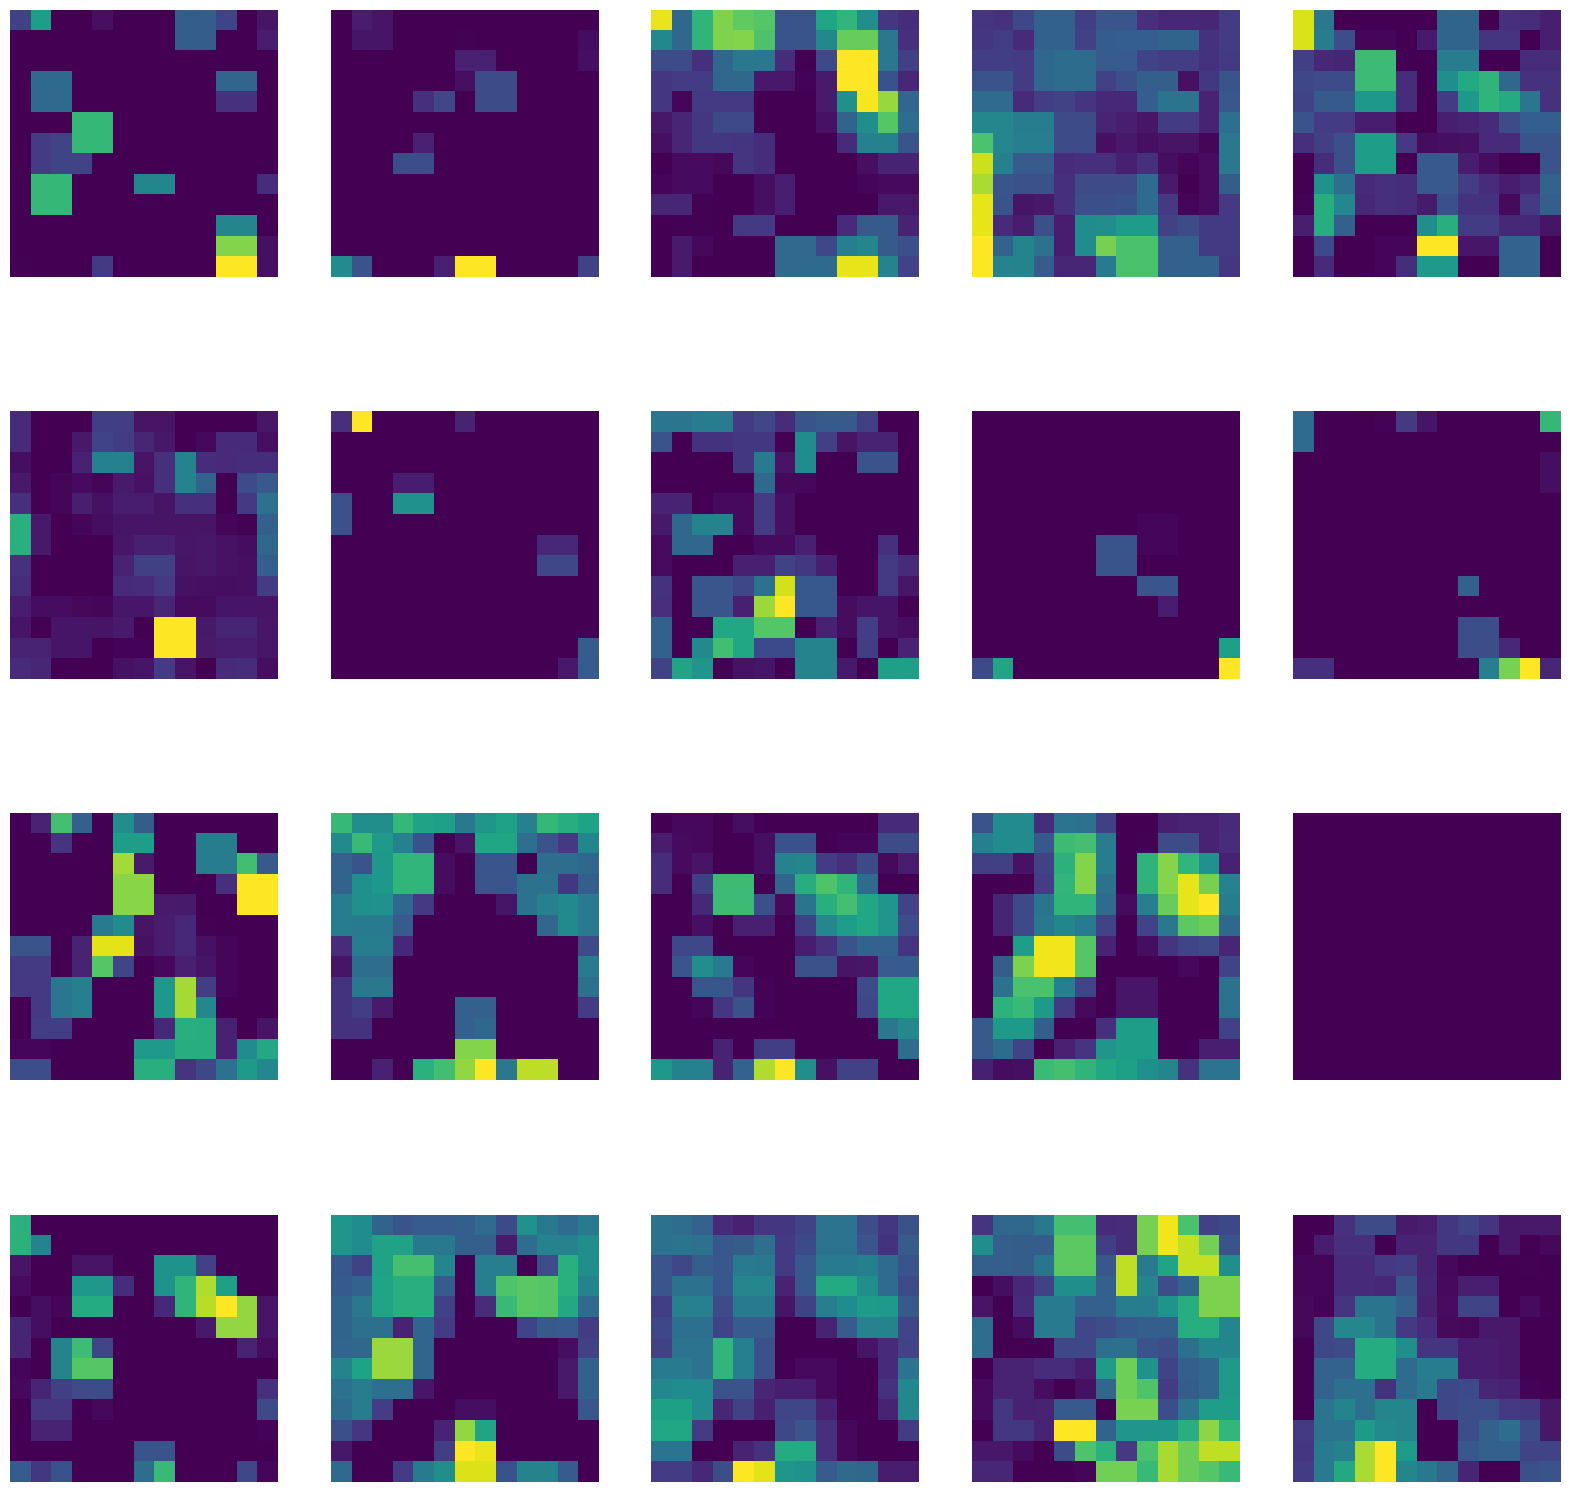

In [ ]:
visualize_feature_maps(before)

#### after perturbations at 'S1'

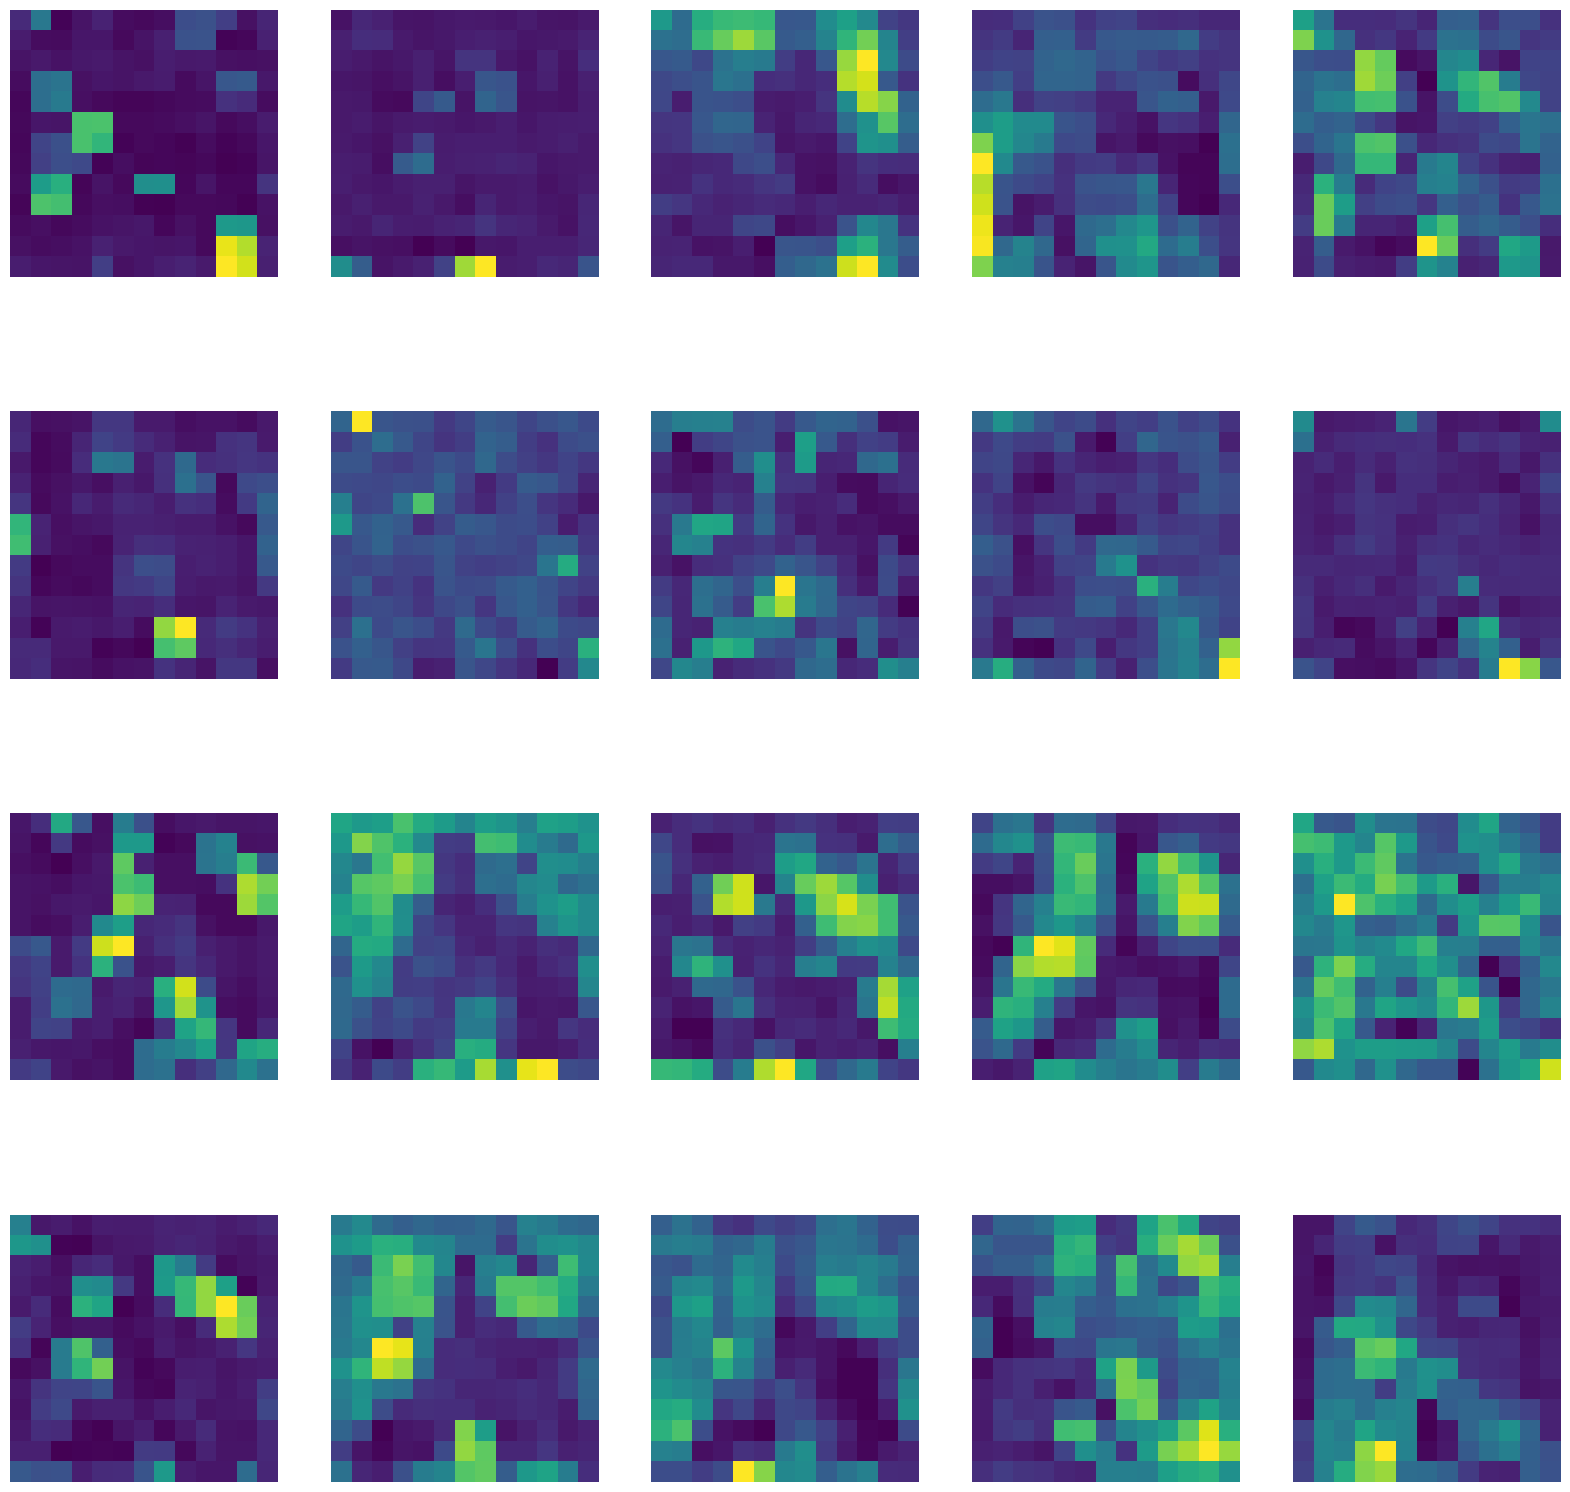

In [ ]:
visualize_feature_maps(after)